In [6]:
import os

# 遍历directory下的所有文件，并且把他们的路径用一个列表进行返回
def get_image_paths(directory):
    return [x.path for x in os.scandir(directory) if x.name.endswith(".jpg") or x.name.endswith(".png")]

images_A = get_image_paths('C:\\Users\\Administrator\\Desktop\\TF_TransferFace\\trump')
images_B = get_image_paths('C:\\Users\\Administrator\\Desktop\\TF_TransferFace\\cage')
print("川普图片个数为 {}\n凯奇的图片个数为 {}".format(len(images_A), len(images_B)))

川普图片个数为 376
凯奇的图片个数为 318


In [7]:
import cv2
import numpy as np

# 批量加载图片，传入的是路径集合，遍历所有的路径，并加载图片
def load_images(image_paths):
    iter_all_images = (cv2.imread(fn) for fn in image_paths)

    # iter_all_images 是一个 generator 类型，将它转换成熟知的 numpy 的列表类型并返回
    for i, image in enumerate(iter_all_images):
        if i == 0:
            # 对all_images 进行初始,并且指定格式
            all_images = np.empty(
                (len(image_paths),) + image.shape, dtype=image.dtype)
        all_images[i] = image

    return all_images

# 每个文件夹加载三张图片
A_images = load_images(images_A[0:3])
B_images = load_images(images_B[0:3])
print(A_images.shape)
print(B_images.shape)

(3, 256, 256, 3)
(3, 256, 256, 3)


In [8]:
# 根据所给的维度长度，告诉调用者哪些维度应该被放入第 0 维度，哪些应该被转换为第 1 维度
# 例如 （2,3,256,256,3） 则是第 0 维，第 2 维合在一起，转换成新的图片的第0维（也就是行的个数）
# 第 1 维，第 3 维合在一起，转换成新的图片的第1维（也就是列的个数）
def get_transpose_axes(n):
    # 根据总长度的奇偶性，来制定不同的情况
    if n % 2 == 0:
        y_axes = list(range(1, n-1, 2))
        x_axes = list(range(0, n-1, 2))
    else:
        y_axes = list(range(0, n-1, 2))
        x_axes = list(range(1, n-1, 2))
    return y_axes, x_axes, [n-1]


# 可以将存储多张图片的多维集合，拼成一张图片
def stack_images(images):
    images_shape = np.array(images.shape)
    # new_axes 得到的是三个列表。[0,2],[1,3],[4] 告诉调用者新集合中的每个维度由旧集合中的哪些维度构成
    new_axes = get_transpose_axes(len(images_shape))
    new_shape = [np.prod(images_shape[x]) for x in new_axes]
    return np.transpose(
        images,
        axes=np.concatenate(new_axes)
    ).reshape(new_shape)

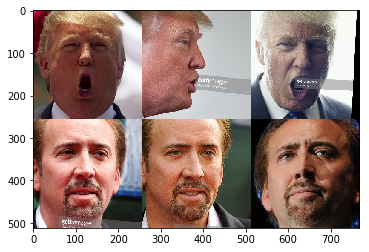

In [9]:
import matplotlib.pyplot as plt  # plt 用于显示图片
figure = np.concatenate([A_images, B_images], axis=0)  # 6,256,256,3
figure = figure.reshape((2, 3) + figure.shape[1:])  # 2,3,256,256,3
figure = stack_images(figure)  # 512,768,3
%matplotlib inline
# 这里需要指定利用 cv 的调色板，否则 plt 展示出来会有色差
plt.imshow(cv2.cvtColor(figure, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
# 子像素卷积层，用于上采样
# PixelShuffler layer for Keras
from keras.utils import conv_utils
from keras.engine.topology import Layer
import keras.backend as K


class PixelShuffler(Layer):
    # 初始化 子像素卷积层，并在输入数据时，对数据进行标准化处理。
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(PixelShuffler, self).__init__(**kwargs)
        self.data_format = K.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')

    def call(self, inputs):
        # 根据得到输入层图层 batch_size，h ，w，c 的大小
        input_shape = K.int_shape(inputs)
        batch_size, h, w, c = input_shape
        if batch_size is None:
            batch_size = -1
        rh, rw = self.size

        # 计算转换后的图层大小与通道数
        oh, ow = h * rh, w * rw
        oc = c // (rh * rw)

        # 先将图层分开，并且将每一层装换到自己应该到维度
        # 最后再利用一次 reshape 函数（计算机会从外到里的一个个的将数据排下来），这就可以转成指定大小的图层了
        out = K.reshape(inputs, (batch_size, h, w, rh, rw, oc))
        out = K.permute_dimensions(out, (0, 1, 3, 2, 4, 5))
        out = K.reshape(out, (batch_size, oh, ow, oc))
        return out

    # compute_output_shape()函数用来输出这一层输出尺寸的大小
    # 尺寸是根据input_shape以及我们定义的output_shape计算的。
    def compute_output_shape(self, input_shape):
        height = input_shape[1] * self.size[0] if input_shape[1] is not None else None
        width = input_shape[2] * self.size[1]  if input_shape[2] is not None else None
        channels = input_shape[3] // self.size[0] // self.size[1]

        return (input_shape[0],
                height,
                width,
                channels)

    # 设置配置文件
    def get_config(self):
        config = {'size': self.size,
                  'data_format': self.data_format}
        base_config = super(PixelShuffler, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))

Using TensorFlow backend.


In [11]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D

# 下采样层,filters 为输出图层的通道数
# n * n * c -> 0.5n * 0.5n * filters
def conv(filters):
    def block(x):
        # 每一层由一个使图层大小减小一半的卷积层和一个 LeakyReLU 激活函数层构成。
        x = Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
        x = LeakyReLU(0.1)(x)
        return x
    return block

# 上采样层，扩大图层大小
# 图层的形状变化如下：
# n*n*c -> n * n * 4filters -> 2n * 2n * filters
def upscale(filters):
    # 每一层由一个扩大通道层的卷积，一个激活函数和一个像素洗牌层
    def block(x):
        # 将通道数扩大为原来的四倍。为了下一步能够通过像素洗牌 使原来的图层扩大两倍
        x = Conv2D(filters*4, kernel_size=3, padding='same')(x)
        x = LeakyReLU(0.1)(x)
        x = PixelShuffler()(x)
        return x
    return block

In [12]:
import tensorflow as tf
# 将原图片转为 Tensor 类型
x1 = tf.convert_to_tensor(A_images, dtype=tf.float32)
x2 = conv(126)(x1)
x3 = upscale(3)(x2)
print("将大小为 {} 的图片传入 filters 为 126 的下采样层中得到大小为 {} 的图层。".format(x1.shape, x2.shape))
print("将大小为 {} 的图层传入 filters 为  3  的上采样层中得到大小为 {} 的图片。".format(x2.shape, x3.shape))

将大小为 (3, 256, 256, 3) 的图片传入 filters 为 126 的下采样层中得到大小为 (3, 128, 128, 126) 的图层。
将大小为 (3, 128, 128, 126) 的图层传入 filters 为  3  的上采样层中得到大小为 (3, 256, 256, 3) 的图片。


In [14]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape

# 定义原图片的大小
IMAGE_SHAPE = (64, 64, 3)
# 定义全连接的神经元个数
ENCODER_DIM = 1024


def Encoder():
    input_ = Input(shape=IMAGE_SHAPE)
    x = input_
    x = conv(128)(x)
    x = conv(256)(x)
    x = conv(512)(x)
    x = conv(1024)(x)
    x = Dense(ENCODER_DIM)(Flatten()(x))
    x = Dense(4*4*1024)(x)
    x = Reshape((4, 4, 1024))(x)
    x = upscale(512)(x)
    return Model(input_, x)


def Decoder():
    input_ = Input(shape=(8, 8, 512))
    x = input_
    x = upscale(256)(x)
    x = upscale(128)(x)
    x = upscale(64)(x)
    x = Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)
    return Model(input_, x)

In [15]:
from tensorflow.keras.optimizers import Adam
# 定义优化器
optimizer = Adam(lr=5e-5, beta_1=0.5, beta_2=0.999)
encoder = Encoder()
decoder_A = Decoder()
decoder_B = Decoder()
# 定义输入函数大小
x = Input(shape=IMAGE_SHAPE)
# 定义解析 A 类图片的神经网络
autoencoder_A = Model(x, decoder_A(encoder(x)))
# 定义解析 B 类图片的神经网络
autoencoder_B = Model(x, decoder_B(encoder(x)))
# 使用同一个优化器，计算损失和的最小值。损失函数采用平均绝对误差
autoencoder_A.compile(optimizer=optimizer, loss='mean_absolute_error')
autoencoder_B.compile(optimizer=optimizer, loss='mean_absolute_error')
# 输出两个对象
autoencoder_A, autoencoder_B

(<keras.engine.training.Model at 0x1e6040ffef0>,
 <keras.engine.training.Model at 0x1e6041171d0>)

In [16]:
# 该函数中所有的参数的值都可以根据情况自行调整。
def random_transform(image):
    h, w = image.shape[0:2]
    # 随机初始化旋转角度，范围 -10 ~ 10 之间。
    rotation = np.random.uniform(-10, 10)
    # 随机初始化缩放比例，范围 0.95 ~ 1.05 之间。
    scale = np.random.uniform(0.95, 1.05)
    # 随机定义平移距离，平移距离的范围为 -0.05 ~ 0.05。
    tx = np.random.uniform(-0.05, 0.05) * w
    ty = np.random.uniform(-0.05, 0.05) * h
    # 定义放射变化矩阵，用于将之前那些变化参数整合起来。
    mat = cv2.getRotationMatrix2D((w//2, h//2), rotation, scale)
    mat[:, 2] += (tx, ty)
    # 进行放射变化，根据变化矩阵中的变化参数，将图片一步步的进行变化，并返回变化后的图片。
    result = cv2.warpAffine(
        image, mat, (w, h), borderMode=cv2.BORDER_REPLICATE)
    # 图片有 40% 的可能性被翻转
    if np.random.random() < 0.4:
        result = result[:, ::-1]
    return result

变化前图片大小为(256, 256, 3)
变化后图片大小为(256, 256, 3)


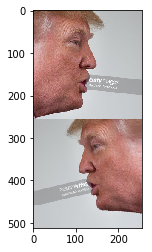

In [17]:
old_image = A_images[1]  # 去之前用于展示的第1张图片
transform_image = random_transform(old_image)
print("变化前图片大小为{}\n变化后图片大小为{}".format(old_image.shape, transform_image.shape))
# 用数据可视化部分的函数进行展示
figure = np.concatenate([old_image, transform_image], axis=0)
figure = stack_images(figure)
# 这里需要指定利用 cv 的调色板，否则 plt 展示出来会有色差
plt.imshow(cv2.cvtColor(figure, cv2.COLOR_BGR2RGB))

In [18]:
def random_warp(image):
    # 先设置映射矩阵
    assert image.shape == (256, 256, 3)
    # 设置 range_ = [ 48.,  88., 128., 168., 208.]
    range_ = np.linspace(128-80, 128+80, 5)
    mapx = np.broadcast_to(range_, (5, 5))  # 利用 Python 广播的特性将 range_ 复制 5 份。
    mapy = mapx.T
    mapx = mapx + np.random.normal(size=(5, 5), scale=5)
    mapy = mapy + np.random.normal(size=(5, 5), scale=5)
    # 将大小为 5*5 的map放大为 80*80 ，再进行切片，得到 64 * 64 的 map
    interp_mapx = cv2.resize(mapx, (80, 80))[8:72, 8:72].astype('float32')
    interp_mapy = cv2.resize(mapy, (80, 80))[8:72, 8:72].astype('float32')

    # 通过映射矩阵进行剪切和卷曲的操作，最后获得 64*64 的训练集图片
    warped_image = cv2.remap(image, interp_mapx, interp_mapy, cv2.INTER_LINEAR)

    # 下面四行代码涉及到 target 的制作，该段代码会在下面进行阐述
    src_points = np.stack([mapx.ravel(), mapy.ravel()], axis=-1)
    dst_points = np.mgrid[0:65:16, 0:65:16].T.reshape(-1, 2)
    mat = umeyama(src_points, dst_points, True)[0:2]  # umeyama 函数的定义见下面代码块
    target_image = cv2.warpAffine(image, mat, (64, 64))

    return warped_image, target_image

In [19]:
# License (Modified BSD)
# umeyama function from scikit-image/skimage/transform/_geometric.py
def umeyama(src, dst, estimate_scale):
    """Estimate N-D similarity transformation with or without scaling.
    Parameters
    ----------
    src : (M, N) array
        Source coordinates.
    dst : (M, N) array
        Destination coordinates.
    estimate_scale : bool
        Whether to estimate scaling factor.
    Returns
    -------
    T : (N + 1, N + 1)
        The homogeneous similarity transformation matrix. The matrix contains
        NaN values only if the problem is not well-conditioned.
    References
    ----------
    .. [1] "Least-squares estimation of transformation parameters between two
            point patterns", Shinji Umeyama, PAMI 1991, DOI: 10.1109/34.88573
    """

    num = src.shape[0]
    dim = src.shape[1]

    # Compute mean of src and dst.
    src_mean = src.mean(axis=0)
    dst_mean = dst.mean(axis=0)

    # Subtract mean from src and dst.
    src_demean = src - src_mean
    dst_demean = dst - dst_mean

    # Eq. (38). 下面的Eq 都分别对应着论文中的公式
    A = np.dot(dst_demean.T, src_demean) / num

    # Eq. (39).
    d = np.ones((dim,), dtype=np.double)
    if np.linalg.det(A) < 0:
        d[dim - 1] = -1

    T = np.eye(dim + 1, dtype=np.double)

    U, S, V = np.linalg.svd(A)

    # Eq. (40) and (43).
    rank = np.linalg.matrix_rank(A)
    if rank == 0:
        return np.nan * T
    elif rank == dim - 1:
        if np.linalg.det(U) * np.linalg.det(V) > 0:
            T[:dim, :dim] = np.dot(U, V)
        else:
            s = d[dim - 1]
            d[dim - 1] = -1
            T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V))
            d[dim - 1] = s
    else:
        T[:dim, :dim] = np.dot(U, np.dot(np.diag(d), V.T))

    if estimate_scale:
        # Eq. (41) and (42).
        scale = 1.0 / src_demean.var(axis=0).sum() * np.dot(S, d)
    else:
        scale = 1.0

    T[:dim, dim] = dst_mean - scale * np.dot(T[:dim, :dim], src_mean.T)
    T[:dim, :dim] *= scale

    return T

In [20]:
warped_image, target_image = random_warp(transform_image)  # 返回训练图片和 target 图片
print("warpe 前图片大小{}\nwarpe 后图片大小{}".format(
    transform_image.shape, warped_image.shape))

warpe 前图片大小(256, 256, 3)
warpe 后图片大小(64, 64, 3)


In [21]:
def get_training_data(images, batch_size):
    # 再分批的同时也把数据集打乱，有序的数据集可能使模型学偏
    indices = np.random.randint(len(images), size=batch_size)
    for i, index in enumerate(indices):
        # 处理该批数据集
        image = images[index]
        # 将图片进行预处理
        image = random_transform(image)
        warped_img, target_img = random_warp(image)

        # 开始分批
        if i == 0:
            warped_images = np.empty(
                (batch_size,) + warped_img.shape, warped_img.dtype)
            target_images = np.empty(
                (batch_size,) + target_img.shape, warped_img.dtype)

        warped_images[i] = warped_img
        target_images[i] = target_img

    return warped_images, target_images

In [22]:
# 加载图片，并对图片进行归一化操作
#注意：由于该段代码之前 images_A 变量名存的是路径，而现在存的是真实的 image 矩阵
#因此如果需要重复重复运行该段代码会报错（这时就需要再运行一下第一部分的加载图片路径的代码块）
images_A = load_images(images_A) / 255.0
images_B = load_images(images_B) / 255.0
images_A += images_B.mean(axis=(0, 1, 2)) - images_A.mean(axis=(0, 1, 2))

# 将数据进行分批，每个批次 20 条
warped_A, target_A = get_training_data(images_A, 20)
warped_A.shape, target_A.shape

((20, 64, 64, 3), (20, 64, 64, 3))

In [23]:
# 保存模型
def save_model_weights():
    encoder  .save_weights("encoder.h5")
    decoder_A.save_weights("decoder_A.h5")
    decoder_B.save_weights("decoder_B.h5")
    print("save model weights")

# 开始训练
epochs = 10  # 这里只用作演示，请在实际训练的时候，至少将其调到 8000 以上

for epoch in range(epochs):
    print("第{}代，开始训练。。。".format(epoch))
    batch_size = 26
    warped_A, target_A = get_training_data(images_A, batch_size)
    warped_B, target_B = get_training_data(images_B, batch_size)
    loss_A = autoencoder_A.train_on_batch(warped_A, target_A)
    loss_B = autoencoder_B.train_on_batch(warped_B, target_B)
    print("lossA:{},lossB:{}".format(loss_A, loss_B))
# 下面都为画图和保存模型的操作
save_model_weights()

第0代，开始训练。。。


lossA:0.19781605899333954,lossB:0.17535468935966492
第1代，开始训练。。。


lossA:0.17746077477931976,lossB:0.17954908311367035
第2代，开始训练。。。


lossA:0.17798925936222076,lossB:0.1798342913389206
第3代，开始训练。。。


lossA:0.17777690291404724,lossB:0.19340437650680542
第4代，开始训练。。。


lossA:0.1724264770746231,lossB:0.19136713445186615
第5代，开始训练。。。


lossA:0.17873342335224152,lossB:0.17515303194522858
第6代，开始训练。。。


lossA:0.18691572546958923,lossB:0.18869327008724213
第7代，开始训练。。。


lossA:0.2017589509487152,lossB:0.1807810366153717
第8代，开始训练。。。


lossA:0.18413199484348297,lossB:0.18363234400749207
第9代，开始训练。。。


lossA:0.18545562028884888,lossB:0.17455966770648956


save model weights
